## Análisis de Opiniones y Características de Listados de Airbnb en Ciudad México

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import nltk
import joblib
import importlib
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# import funciones
from wordcloud import WordCloud

### 1. Carga de los datos y exploración inicial
- Cargamos los datos de Airbnb y realizamos una exploración inicial para entender la estructura y el contenido de los datos.
- Exploramos la columna objetivo: `review_scores_rating`.
- Eliminamos los items sin puntuación.
- Realizamos el etiquetado binario.
- Visualizamos la distribución de la nueva columna `target`.

In [36]:
df_listings = pd.read_csv('data/listings.csv')
df_reviews = pd.read_csv('data/reviews.csv')

- Revisamos la cantida de datos que tenemos en ambos dataframes.
- Verificamos que en los reviews no hayan ids que no se encuentren en listings.

In [37]:
print("Tamaño de df_listings:", df_listings.shape)
print("Tamaño de df_reviews:", df_reviews.shape)

Tamaño de df_listings: (26067, 79)
Tamaño de df_reviews: (1315986, 6)


In [38]:
missing_ids = set(df_reviews['listing_id']) - set(df_listings['id'])

In [39]:

print(f"Total de Propiedades: {df_listings['id'].nunique()}")
print(f"Total de Reseñas: {len(df_reviews)}")
print(f"Total de propiedades únicas reseñadas: {df_reviews['listing_id'].nunique()}")
print(f"Avg Reseñas/Propiedades: {len(df_reviews)/df_reviews['listing_id'].nunique():.1f}")

Total de Propiedades: 26067
Total de Reseñas: 1315986
Total de propiedades únicas reseñadas: 22806
Avg Reseñas/Propiedades: 57.7


In [40]:
print("Valores nulos en la variable objetivo: ",df_listings['review_scores_rating'].isnull().sum())
df_listings = df_listings.dropna(subset=['review_scores_rating'])
print("Valores nulos en la variable objetivo después de eliminar: ",df_listings['review_scores_rating'].isnull().sum())

Valores nulos en la variable objetivo:  3261
Valores nulos en la variable objetivo después de eliminar:  0


In [41]:
df_listings["target"] = (df_listings["review_scores_rating"] >=4.6).astype(int)
print(df_listings["target"].value_counts())

target
1    19216
0     3590
Name: count, dtype: int64


/tmp/ipykernel_20589/4149877364.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_listings, x='target', palette='viridis')


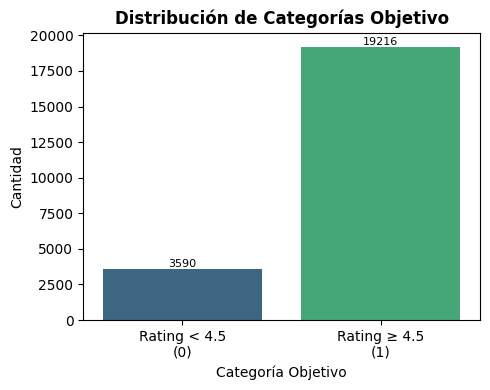

In [42]:
plt.figure(figsize=(5, 4))
sns.countplot(data=df_listings, x='target', palette='viridis')

# Add labels and title
plt.title('Distribución de Categorías Objetivo', fontsize=12, fontweight='bold')
plt.xlabel('Categoría Objetivo', fontsize=10)
plt.ylabel('Cantidad', fontsize=10)

# Add value labels on top of bars
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=8)

plt.xticks([0, 1], ['Rating < 4.5\n(0)', 'Rating ≥ 4.5\n(1)'])

# Adjust layout and display
plt.tight_layout()
plt.show()

Notamos que hay un gran desbalance en la categoría objetivo. Esto será algo importante a tener en cuenta al momento de elegir, entrenar y evaluar los modelos.

## 2. Preprocesamiento del texto
- Eliminamos caracteres especiales, números y stopwords.
- Convertimos todo a minúsculas.
- Realizamos lematización para reducir las palabras a su forma base.
- Creamos una nueva columna en el dataframe de reviews con el texto preprocesado.